<a id='top'></a>
<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/>

# NIRSpec MOS MSA metafile

The 
[MSA metadata file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html)
records information about 
NIRSpec [MOS](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-multi-object-spectroscopy) (multi-object spectroscopy)
[MSA](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly) (mirco-shutter assembly)
configurations as planned by 
[APT](https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview)'s
[MSA Planning Tool (MPT)](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-apt-templates/nirspec-multi-object-spectroscopy-apt-template/nirspec-msa-planning-tool-mpt):

* `SHUTTER_IMAGE` (2D array): map of which MSA shutters were open and closed
* `SHUTTER_INFO` (table): for each shutter, it is part of a longer slit, and does it contain a science target or empty background?
* `SOURCE_INFO` (table): catalog of science targets plus fake targets in empty slits

They are used by the 
[JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline) 
to extract spectra for sources.
The files are available on MAST.
Each NIRSpec MOS data product includes the name of the associated MSA metadata file in its header (keyword `MSAMETFL`).

The pipeline expects the MSA metadata file to be in the same directory as the input data files. Below, we demonstrate editing the MSA metafile. We save this file in a new directory *using the same filename* and link to the data files from that directory. The pipeline can then be run from that directory, and the headers will still point to the MSA metadata file. 
Alternatively, if the updated MSA metadata file were given a new filename, then you must also edit the data file headers to point to the new MSA metadata file.

Below we explore MSA metadata file contents and show how to edit it for:
* subset of sources
* science vs. background shutters
* point source vs. extended targets (used by the path loss correction)

Finally we show how to:
* view the shutter image map

MSA metadata file edits are also covered in other example notebooks:
* [NSClean](https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_MOS/nrs_mos_clean_1f_noise_workaround.ipynb)
* [JWebbinar 7](https://github.com/spacetelescope/jwebbinar_prep/blob/faf56cd5f2cadca15e72be4180cd7f957ff3b1d8/mos_session/jwebbinar7_nirspecmos.ipynb) also on NIRSpec MOS pipeline processing

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack, unique

In [2]:
def single_value(x):  # True = one number; False = multiple numbers (list / tuple / array / set)
    return isinstance(x, (int, float))

def filter_table(full_table, **kwargs):
    """
    Filters an Astropy Table based an arbitrary number of input column-value pairs.
    Each value can be either a single value or a list (or tuple, array, or set).
    Example:
    select_shutter_table = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1, source_id=[6355,5144])
    """
    filtered_table = full_table
    for column, value in kwargs.items():
        if single_value(value):
            filtered_table = filtered_table[filtered_table[column] == value]
        else: # list
            filtered_table = filtered_table[[(item in value) for item in filtered_table[column]]]
    return filtered_table

In [3]:
# To retrieve data from MAST
import astroquery
from astroquery.mast import Observations  # MAST
print('astroquery version', astroquery.__version__)

# Helper function to download JWST files from MAST
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    """
    Helper function to download JWST files from MAST.

    Parameters:
    ----------
    filenames: list of str
        List of filenames to download.
    download_dir: str
        Directory where the files will be downloaded.
    mast_dir: str
        MAST directory containing JWST products.

    Returns:
    -------
    downloaded_files: list of str
        List of downloaded file paths.
    """
    # Download data
    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename = os.path.basename(filename)
        mast_path = os.path.join(mast_dir, filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists
            # However, it will delete it if it's there
            # and the wrong size (e.g., reprocessed)
            Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

astroquery version 0.4.7


In [4]:
# Create links in output_dir directory to source files
def link_to_files(source_files, output_dir):
    for source_file in source_files:
        link = os.path.join(output_dir, os.path.basename(source_file))
        print(link, '->', source_file)
        if not os.path.exists(link):
            os.symlink(os.path.abspath(source_file), link)

In [5]:
import requests

def download_file(url, download_dir=''):  # simple for small files
    filename = os.path.basename(url)
    if download_dir:
        if os.path.isdir(download_dir):
            filename = os.path.join(download_dir, filename)
    if os.path.exists(filename):
        print(filename, 'EXISTS')
    else:
        print('DOWNLOADING', filename)
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    return filename

# MSA metafile



In [6]:
# If you know the filename, you can skip this section
#msa_metafile = 'jw02736007001_01_msa.fits'

In [7]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [8]:
source_id = 6355  # z = 7.665
data_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
data_file = download_jwst_files([data_file], data_dir)[0]
data_file

'data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [9]:
msa_metafile_name = fits.getval(data_file, 'MSAMETFL')
msa_metafile_name

'jw02736007001_01_msa.fits'

In [10]:
msa_metafile = download_jwst_files([msa_metafile_name], data_dir)[0]
msa_metafile

'data/jw02736007001_01_msa.fits'

# Load MSA metafile and inspect contents

In [11]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [12]:
# Load these tables; we'll inspect and edit them below
source_table  = Table(msa_hdu_list['SOURCE_INFO'].data)
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)

In [13]:
msa_hdu_list['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'STSCI   '           / institution responsible for creating FITS file 
TELESCOP= 'JWST    '           / telescope used to acquire data                 
INSTRUME= 'NIRSPEC '           / identifier for instrument used to acquire data 
DATE    = '2022-12-08T02:18:08'                                                 
FILENAME= 'jw02736007001_01_msa.fits' / name of file                            
PPSDBVER= 'PPSDB95 '           / version of PPS database used                   
PROGRAM = '02736   '           / program number                                 
VISIT   = '001     '           / visit number                                   
OBSERVTN= '007     '        

In [14]:
msa_hdu_list['PRIMARY'].header['DATE']

'2022-12-08T02:18:08'

In [15]:
# The datamodel shows the same info in a longer format
#from jwst import datamodels
#msa_model = datamodels.open(msa_metafile)
#msa_model.info(max_rows=99999)

# Source Table

The `SOURCE_INFO` table contains information on each source in the input catalog.  
"Virtual" sources in empty slits are assigned negative numbers, in sequence.  
The [source type](https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/description.html) 
is also encoded:
* 0.0 <= `stellarity` <= 0.75: extended
* otherwise: point source

| SOURCE_INFO | Description |
|:-:|:-|
| `PROGRAM` | JWST program ID |   
| `SOURCE_ID` | Unique integer identifier: positive (real sources) or negative (virtual sources) |   
| `SOURCE_NAME` | Typically a combination of the first two columns |
| `ALIAS` | Either the source ID (real sources) or the RA, Dec (virtual sources) |   
| `RA`/`DEC` | Catalog source coordinates, in decimal degrees |   
| `PREIMAGE_ID` | Name of NIRCam pre-imaging mosaic used to determine the source catalog, if it exists |   
| `STELLARITY` | Float ranging from 0 (fully extended) to 1 (point source). <br> The pipeline treats 0 <= stellarity <= 0.75 as extended for path loss corrections. |   
[More Info ...](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats#JWSTNIRSpecMOSPipelineCaveats-msa_metafileMetadataforsourceandslitletinformation)

In [16]:
source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,-62,2736_-62,07:23:51.1052 -73:26:51.57,110.96293832677276,-73.44765753038087,None,0.0
2736,-61,2736_-61,07:23:28.8142 -73:25:52.13,110.87005912412539,-73.43114667764434,None,0.0
2736,-60,2736_-60,07:23:17.7994 -73:25:43.20,110.82416419252095,-73.42866585631378,None,0.0
2736,-59,2736_-59,07:23:37.7429 -73:27:0.58,110.90726211582383,-73.45016176434785,None,0.0
2736,-58,2736_-58,07:23:18.8600 -73:26:4.96,110.82858331230773,-73.43471113068318,None,0.0
2736,-57,2736_-57,07:23:17.1182 -73:26:4.80,110.82132592002846,-73.43466605654396,None,0.0
2736,-56,2736_-56,07:23:15.2432 -73:26:1.05,110.81351353799377,-73.43362537508722,None,0.0
2736,-55,2736_-55,07:23:46.9483 -73:27:57.15,110.94561802608843,-73.46587623588209,None,0.0
2736,-54,2736_-54,07:23:42.4293 -73:27:43.60,110.92678854842542,-73.46211224629303,None,0.0


# Shutter Table



The `SHUTTER_INFO` table specifies all the slitlets having one or more open shutters based on the MSA configuration for that observation.  

| SHUTTER_INFO | Description |
|:-:|:-|
| `SLITLET_ID` | Integer number representing each slitlet of one or more open shutters specified in the MSA configuration |  
| `MSA_METADATA_ID` | Integer number corresponding to a particular MSA configuration / MPT plan <br> (one metafile may contain multiple MSA configurations) |
| `SHUTTER_QUADRANT` | MSA quadrant (1, 2, 3, 4) |
| `SHUTTER_ROW` | Row number decreases in the dispersion direction (transposed with respect to science data) |
| `SHUTTER_COLUMN` | Column number increases in the spatial cross-dispersion direction |
| `SOURCE_ID` | Unique integer ID for each source in each slitlet, used for matching to the SOURCE_INFO table |
| `BACKGROUND` | Boolean indicating whether the shutter is open to background (Y) or contains a known source (N) (for a given nod exposure if the observation includes nodding) | 
| `SHUTTER_STATE` | Generally, this will always be OPEN, unless a long slit was used |
| `ESTIMATED_SOURCE_IN_SHUTTER_X/Y` | The position of the source within the shutter in relative units (where 0,0 is the bottom left corner and 0.5,0.5 is the center), as planned in MPT |
| `DITHER_POINT_INDEX` | Integer specifying the index of the nod sequence; matches with the data primary header keyword PATT_NUM | 
| `PRIMARY_SOURCE` | Boolean indicating whether the shutter contains the science source |
[More Info ...](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats#JWSTNIRSpecMOSPipelineCaveats-msa_metafileMetadataforsourceandslitletinformation)

In [17]:
shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
2,1,2,67,50,-1,Y,OPEN,nan,nan,1,N
2,1,2,67,50,-1,N,OPEN,0.5128208,0.49434295,2,Y
2,1,2,67,50,0,Y,OPEN,nan,nan,3,N
2,1,2,67,51,-1,N,OPEN,0.5002731,0.49997795,1,Y
2,1,2,67,51,-1,Y,OPEN,nan,nan,2,N
2,1,2,67,51,0,Y,OPEN,nan,nan,3,N
2,76,2,67,50,-32,Y,OPEN,nan,nan,1,N
2,76,2,67,50,-32,N,OPEN,0.5128208,0.49434295,2,Y
2,76,2,67,50,0,Y,OPEN,nan,nan,3,N


In [18]:
# multiple MSA configurations are often defined in a single file
msa_metadata_ids = list(set(shutter_table['msa_metadata_id']))
msa_metadata_ids

[1, 76]

In [19]:
# MSA metadata ids and slitlet ids are all numbered sequentially, picking up where the other left off
# Here, after the first metadata id 1, the slitlets are numbered 2 – 75, followed by the next metadata id 76
slitlet_ids = np.sort(list(set(shutter_table['slitlet_id'])))
slitlet_ids

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75], dtype=int16)

In [20]:
shutter_table_dither1 = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1)
shutter_table_dither1

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
2,1,2,67,50,-1,Y,OPEN,nan,nan,1,N
2,1,2,67,51,-1,N,OPEN,0.5002731,0.49997795,1,Y
3,1,2,84,85,-2,N,OPEN,0.50021464,0.5000087,1,Y
4,1,1,86,159,-3,Y,OPEN,nan,nan,1,N
4,1,1,86,160,-3,N,OPEN,0.49981627,0.499644,1,Y
5,1,2,88,56,-4,N,OPEN,0.5003102,0.4999598,1,Y
6,1,1,94,149,-5,N,OPEN,0.49975815,0.49966425,1,Y
7,1,1,103,129,-6,Y,OPEN,nan,nan,1,N
7,1,1,103,130,-6,N,OPEN,0.4996756,0.49972537,1,Y


## Trim MSA metafile to subset of objects

In [21]:
#select_source_ids = -8, -9, -11, -12, -13, -16, -26, -27, -28, -29, -38, -41, -43, -57, -58, -59  # empty? backgrounds
select_source_ids = 6355, 5144, 4590, 10612, 8140, 9922  # featured high-z galaxies

select_source_table  = filter_table(source_table,  source_id=select_source_ids)
select_shutter_table = filter_table(shutter_table, source_id=select_source_ids)

## Set sources to point source or extended

Path loss corrections will use this

In [40]:
# Here we'll simply set them all to point source
select_source_table['stellarity'] = 1  # 0 = extended; 1 = point source

## Set shutters to background
could do this but won't here

In [23]:
# Master Background
#select_shutter_table['background']     = 'Y'
#select_shutter_table['primary_source'] = 'N'

## Show modified source table

In [24]:
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,4590,2736_4590,4590,110.85932870207512,-73.44916559196156,None,1.0
2736,5144,2736_5144,5144,110.83967390292369,-73.44535697626878,None,1.0
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,1.0
2736,8140,2736_8140,8140,110.78800223894049,-73.46186797161636,None,1.0
2736,9922,2736_9922,9922,110.85975635074477,-73.44421005964534,None,1.0
2736,10612,2736_10612,10612,110.83396490643933,-73.43452316524234,None,1.0


## Show modified shutter table

In [25]:
# Show contents but just for the first config and dither
filter_table(select_shutter_table, msa_metadata_id=1, dither_point_index=1)

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
16,1,1,173,113,8140,Y,OPEN,nan,nan,1,N
16,1,1,173,114,8140,N,OPEN,0.6575784,0.36736715,1,Y
16,1,1,173,115,8140,Y,OPEN,nan,nan,1,N
51,1,3,19,117,5144,Y,OPEN,nan,nan,1,N
51,1,3,19,118,5144,Y,OPEN,nan,nan,1,N
51,1,3,19,119,5144,Y,OPEN,nan,nan,1,N
51,1,3,19,120,5144,Y,OPEN,nan,nan,1,N
51,1,3,19,121,5144,N,OPEN,0.51558393,0.08815128,1,Y
51,1,3,19,122,5144,Y,OPEN,nan,nan,1,N


## Save modified MSA metafile

In [26]:
output_dir = 'reprocess_subset'
os.makedirs(output_dir, exist_ok=True)

output_msa_metafile = os.path.join(output_dir, msa_metafile_name)
output_msa_metafile

'reprocess_subset/jw02736007001_01_msa.fits'

In [27]:
msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   ['I', 'I', 'I', 'I', 'I', 'J', '1A', '6A', 'E', 'E', 'I', '1A']   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   ['J', 'J', '20A', '31A', 'D', 'D', '30A', 'D']   


In [28]:
msa_hdu_list['SHUTTER_INFO'] = fits.table_to_hdu(select_shutter_table)
msa_hdu_list['SOURCE_INFO']  = fits.table_to_hdu(select_source_table)

msa_hdu_list[2].name = 'SHUTTER_INFO'
msa_hdu_list[3].name = 'SOURCE_INFO'

msa_hdu_list.info()

Filename: data/jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   144R x 12C   ['I', 'I', 'I', 'I', 'I', 'J', '1A', '6A', 'E', 'E', 'I', '1A']   
  3  SOURCE_INFO    1 BinTableHDU     25   6R x 8C   ['J', 'J', '20A', '31A', 'D', 'D', '30A', 'D']   


In [29]:
print('SAVING', output_msa_metafile)
msa_hdu_list.writeto(output_msa_metafile, overwrite=True)
#msa_hdu_list.close()  # let's keep this open to use below

SAVING reprocess_subset/jw02736007001_01_msa.fits


# Link to files in preparation for pipeline

We won't run the pipeline in this notebook, but this shows you how to prepare.  
When you run the pipeline on these linked files in this new directory, it will find the updated metafile there.

In [30]:
rate_files = sorted(glob(os.path.join(data_dir, '*_rate.fits*')))
link_to_files(rate_files, output_dir)

In [31]:
asn_files = sorted(glob(os.path.join(data_dir, '*_asn.json')))
link_to_files(asn_files, output_dir)

# Shutter Image

Translate shutter (column, row) coordinates from the MSA metafile to the observed coordinate system as shown in APT.

The MSA coordinate system is shown on JDox:  
https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly  
Note for each quadrant, the origin is at top right, and numbers increase to the bottom left corner.

The JWST pipeline generates an [MSA metafile](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html)
that uses a similar coordinate system in the `SHUTTER_INFO` *except* that:

* rows and columns are swapped:
    * columns increment in the spatial direction
    * row numbers decrease in the dispersion direction
    
The MSA metafile `SHUTTER_IMAGE` combines all 4 quadrants into one 2D array:  

* numbers are continuous without gaps
    * the origin (1,1) is at top right
    * (730,342) is at bottom left
    
...but only after shuffling them:  
* quadrants are reordered as shown below:

NIRSpec MSA quadrants:  
Q3 Q1  
Q4 Q2  

MSA metafile coordinates:  
Q3 Q4  
Q2 Q1

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib notebook  # interactive plots
%matplotlib inline
import copy

In [33]:
shutter_image = msa_hdu_list['SHUTTER_IMAGE'].data[:].T

ny, nx = shutter_image.shape

Q4 = shutter_image[:ny//2, :nx//2]
Q3 = shutter_image[:ny//2, nx//2:]
Q1 = shutter_image[ny//2:, :nx//2]
Q2 = shutter_image[ny//2:, nx//2:]

msa_image = np.vstack((np.hstack((Q1, Q3)), np.hstack((Q2, Q4))))
msa_image.shape  # ny, nx

(342, 730)

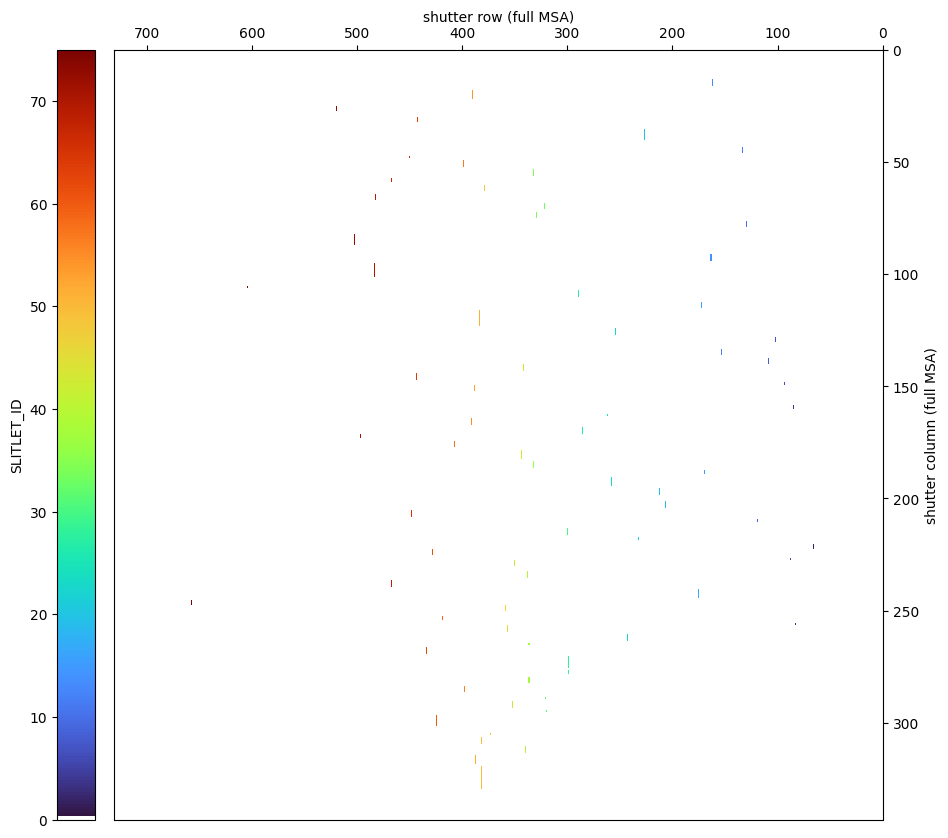

In [34]:
fig, ax = plt.subplots(figsize=(12,10))
cmap = copy.deepcopy(mpl.colormaps['turbo'])
cmap.colors[0] = 1, 1, 1
extent = 0.5, nx+0.5, ny+0.5, 0.5  # origin=(1,1); range = 1..nx, 1..ny with +/-0.5 boundary on either side
im = plt.imshow(msa_image, aspect=nx/ny, interpolation='nearest', cmap=cmap, extent=extent)
plt.xlim(nx+1,0)
plt.ylim(ny+1,0)
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')

### Shutter Image from Shutter Table

In [35]:
def even(x): # even vs. odd number
    return 1 - x % 2

quadrant = shutter_table_dither1['shutter_quadrant']
slitlet  = shutter_table_dither1['slitlet_id']

# row, column resets within each quadrant
row_in_quadrant    = shutter_table_dither1['shutter_row']
column_in_quadrant = shutter_table_dither1['shutter_column']

# row, column on full msa grid
msa_row    = row_in_quadrant    + (quadrant > 2) * nx//2
msa_column = column_in_quadrant + even(quadrant) * ny//2

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_50013/3273560917.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 2 Axes> than <Figure size 1200x1000 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')


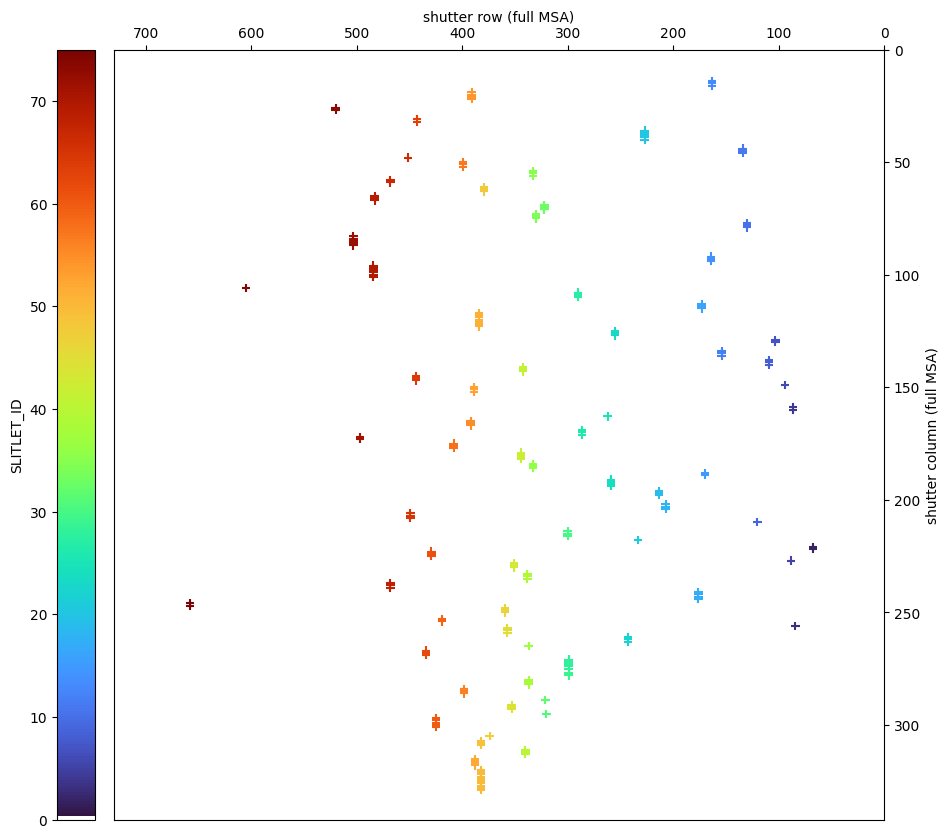

In [36]:
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(msa_row, msa_column, c=slitlet, marker='+', cmap=cmap, clim=(0,np.max(slitlet)))
plt.xlim(nx,0)
plt.ylim(ny,0)
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_aspect(nx/ny)
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')

### Shutter Image from APT

From APT – MPT – Plans – Pointings – Export Config.  
This returns a CSV file with a 2D map of all shutters for that MSA configuration:
* 1 = closed
* 0 = open

In [37]:
msa_config_file = 'https://raw.githubusercontent.com/dancoe/NIRSpec_MOS_JWebbinar/main/data/2736.p1c1-2e1n1.csv'
msa_config_file = download_file(msa_config_file, data_dir)
msa_config_file

DOWNLOADING data/2736.p1c1-2e1n1.csv


'data/2736.p1c1-2e1n1.csv'

In [38]:
import csv
with open(msa_config_file, 'r') as f:
    reader = csv.reader(f)
    msa_config_data = list(reader)
    
msa_config_data = np.array(msa_config_data[1:])  # remove first line header
msa_config_data = msa_config_data.astype(int).T

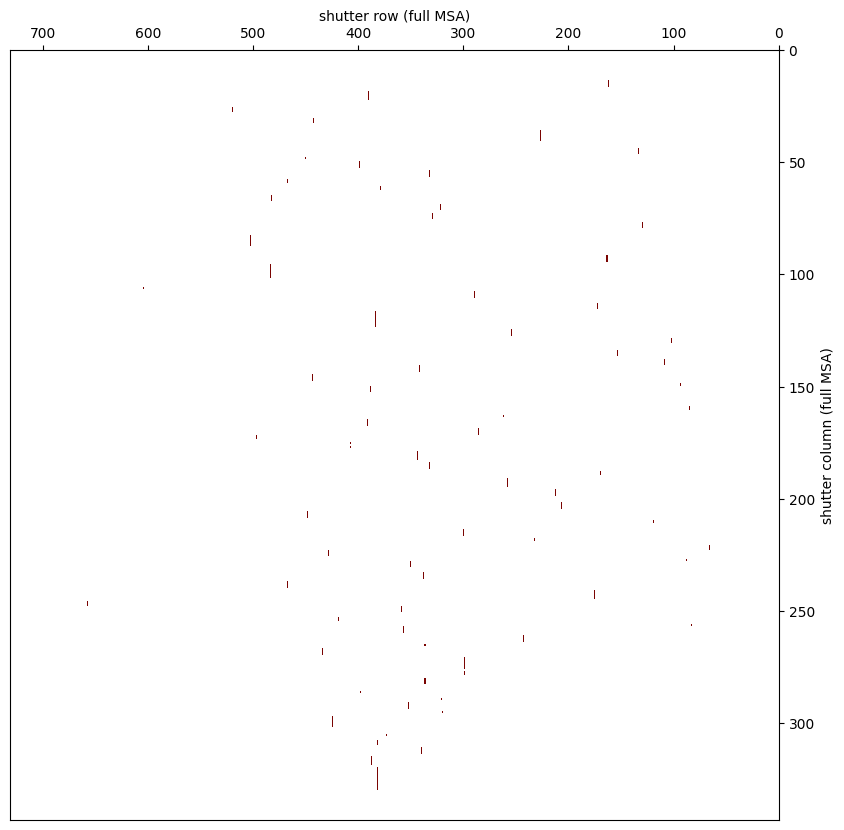

In [39]:
fig, ax = plt.subplots(figsize=(12,10))
cmap = copy.deepcopy(mpl.colormaps['turbo'])
cmap.colors[0] = 1, 1, 1
extent = 0.5, nx+0.5, ny+0.5, 0.5  # origin=(1,1); range = 1..nx, 1..ny with +/-0.5 boundary on either side
im = plt.imshow(1 - msa_config_data, aspect=nx/ny, interpolation='nearest', extent=extent, cmap=cmap)
plt.xlim(nx+1,0)
plt.ylim(ny+1,0)
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

# About this notebook <a id='about'></a>

**Authors:** Dan Coe (dcoe@stsci.edu) and Kayli Glidic with contributions from others on the STScI NIRSpec team.

**Updated:** June 2024

---

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Top of Page](#top)   